# Train WPOD-NET Detector for Frontalization

วิธีการ train WPOD-NET สำหรับทำ License Plate (LP) Frontalization

## 1. ข้อมูลที่ใช้ train เป็นรูปรถ กับ normalized coordinate ของป้ายทะเบียน

In [1]:
import cv2
import os
import random
from glob import glob
import numpy as np
from os.path import splitext, isfile
import matplotlib.pyplot as plt
%matplotlib inline

from src.label import readShapes

sample_path = 'samples/train-detector'

In [2]:
all_img_fn = []
for ext in ('*.png', '*.jpg'):
    all_img_fn.extend(glob(os.path.join(sample_path, ext)))

In [3]:
Data = []
for file in all_img_fn:
    labfile = splitext(file)[0] + '.txt'
    if isfile(labfile):
        L = readShapes(labfile)
        I = cv2.imread(file)
        Data.append([I,L[0]])

print('%d images with labels found' % len(Data))

195 images with labels found


รูปรถมีขนาดเท่าไหร่ก็ได้ data augmentation จะ crop รูปบริเวณป้ายทะเบียนเอง

ส่วนตำแหน่งป้ายทะเบียนระบุด้วย polygon โดยระบุตำแหน่งด้วย normalized coordinate ที่มีค่าอยู่ในช่วง [0, 1] โดยที่ 0 คือ ตำแหน่งซ้าย/บนสุด และ 1 คือ ตำแหน่งขวา/ล่างสุด สำหรับ xy-coordinate ตามลำดับ LP polygon ต้องมี 4 จุด ระบุตำแหน่ง 4 มุมของป้ายทะเบียน โดยเขียนในรูป matrix ขนาด 2\*4 โดยที่แถวแรกระบุ x-coordinate ส่วนแถวที่สองระบุ y-coordinate ส่วนแต่ละคอลัมน์คือ 1 มุม

ซึ่งเวลาเก็บข้อมูล LP polygon ใน text file จะเก็บในลักษณะนี้ 

N,tlx,trx,brx,blx,tly,try,bry,bly,LABEL,

รายละเอียดระบุใน https://docs.google.com/document/d/1NNRH_Sx5zXTAMch198R5LRtdIsdXibDU1qS-EQFtDlM/edit?usp=sharing

ซึ่งสามารถอ่านด้วย class `Shape` ในไฟล์ `src/label.py`

[[0.226646 0.270107 0.27149  0.227831]
 [0.637556 0.634041 0.660403 0.663215]]


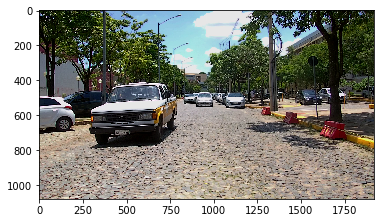

In [4]:
img, label = random.choice(Data)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(label.pts)

รูปรถ (ป้ายทะเบียน) ที่ใช้ train ควรมี resolution หลากหลาย เพื่อความ generalization

รายการข้างล่างแสดงขนาดรูปรถทั้งหมดใน training data ที่ใช้ในเปเปอร์ ซึ่งมีตั้งแต่ 183\*275 ถึง 2592\*3888 pixels

In [5]:
Isizes = [I.shape for I, L in Data]
un, ind = np.unique(Isizes, axis=0, return_index=True)
for idx, s in zip(ind, un):
    print(all_img_fn[idx], '\t', s)

samples/train-detector/01004.jpg 	 [183 275   3]
samples/train-detector/00701.jpg 	 [199 300   3]
samples/train-detector/00686.jpg 	 [225 400   3]
samples/train-detector/00500.jpg 	 [230 297   3]
samples/train-detector/01064.jpg 	 [255 320   3]
samples/train-detector/00154.jpg 	 [260 400   3]
samples/train-detector/00326.jpg 	 [261 450   3]
samples/train-detector/00865.jpg 	 [274 400   3]
samples/train-detector/00167.jpg 	 [275 440   3]
samples/train-detector/00311.jpg 	 [280 280   3]
samples/train-detector/00062.jpg 	 [280 450   3]
samples/train-detector/00690.jpg 	 [300 450   3]
samples/train-detector/00408.jpg 	 [300 479   3]
samples/train-detector/00798.jpg 	 [300 580   3]
samples/train-detector/00755.jpg 	 [300 800   3]
samples/train-detector/00081.jpg 	 [301 550   3]
samples/train-detector/00872.jpg 	 [338 510   3]
samples/train-detector/00160.jpg 	 [350 625   3]
samples/train-detector/00333.jpg 	 [354 500   3]
samples/train-detector/00366.jpg 	 [355 538   3]
samples/train-detect

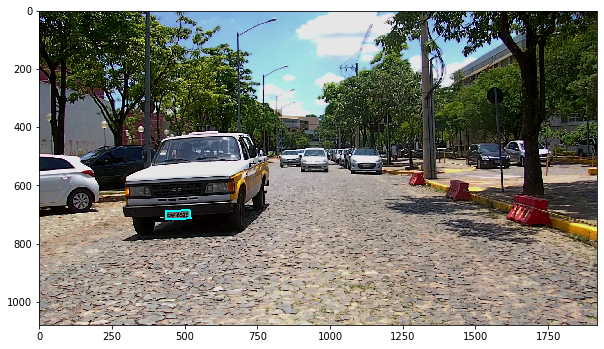

In [6]:
# show training data
h, w, _ = img.shape
pts = label.pts * [[w], [h]]
pts = pts.transpose().astype(np.int32)
pts = pts.reshape((-1,1,2))

cv2.polylines(img,[pts],True,(255,255,0),thickness=5)
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ตัวอย่างภาพรถ และตำแหน่งป้ายทะเบียนที่ใช้ในการ train

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


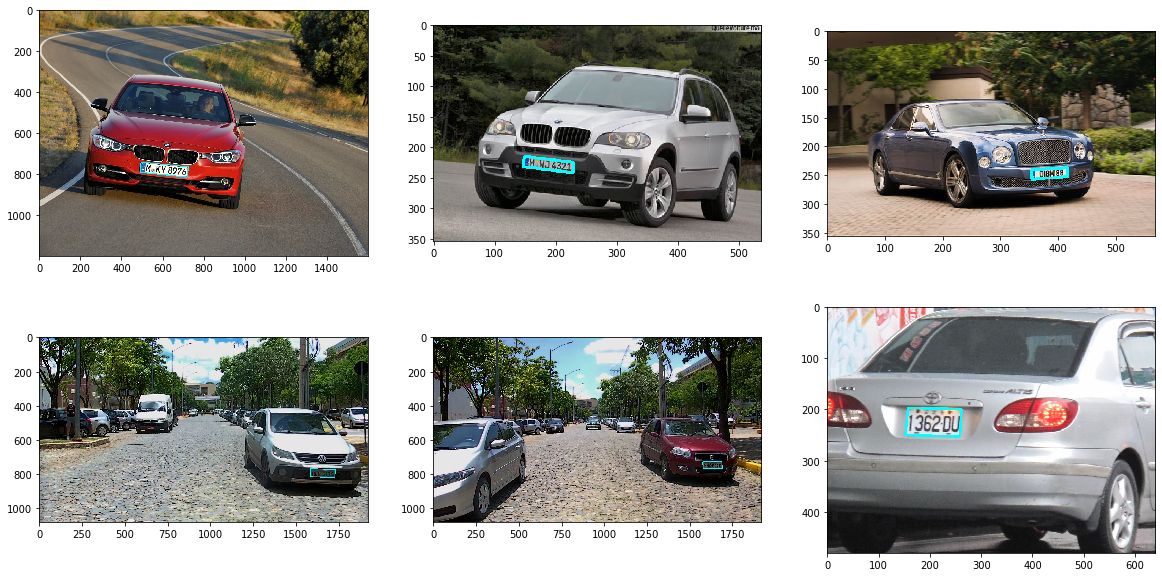

In [7]:
def get_img_lp(img, label):
    h, w, _ = img.shape
    pts = label.pts * [[w], [h]]
    pts = pts.transpose().astype(np.int32)
    pts = pts.reshape((-1,1,2))
    
    cv2.polylines(img,[pts],True,(255,255,0),thickness=3)
    return img


fig, axs = plt.subplots(2,3, figsize=(20,10))
for rows in axs:
    for ax in rows:
        img, label = random.choice(Data)
        img = get_img_lp(img, label)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fig.show()

## 2. ข้อมูล input/output ของ model

In [8]:
td = __import__('train-detector')

Using TensorFlow backend.


In [9]:
from src.keras_utils import save_model, load_model
dim 		= 208
model_arg = 'models/eccv-model-scracth'
model,model_stride,xshape,yshape = td.load_network(model_arg,dim)

ข้อมูล input เป็นรูปบริเวณป้ายทะเบียนขนาด dim\*dim\*3 ซึ่งในเปเปอร์กำหนด dim=208 

In [10]:
print(xshape)

(208, 208, 3)


ส่วนข้อมูล ground truth **(ระวังว่า ground truth หรือ ค่าที่ส่งให้ model ทำนายเป็นตำแหน่งของป้ายทะเบียน ในขณะที่ model output เป็น affine transformation ดังนั้น ฟังก์ชัน loss ต้องทำการแปลให้สองค่านี้เปรียบเทียบกันได้ก่อน ดูโค้ดใน `src/loss.py`)** เป็นภาพที่ถูกย่อลง `model_stride` เท่า จาก max pooling 4 ครั้ง ที่มี 9 channels ซึ่งระบุ bit mask และตำแหน่งของมุมป้ายทะเบียนทั้ง 8 ค่า (xy-coordinate ของ 4 มุม) ที่ถูก normalize ให้ตรงกับขนาด output โดยใช้สูตรนี้ 
$$ A_{mn}(p) = \frac{1}{\alpha} \left( \frac{1}{N_s} p - \begin{bmatrix} n \\ m \end{bmatrix} \right) $$

โดย $m,n$ คือตำแหน่งใน output matrix

$N_s$ คือ model_stride

และ $\alpha$ เป็น scaling constant ในเปเปอร์ใช้ 7.75 สำหรับ dim=208 และ $N_s = 16$ คำนวณโดยเอาจุดกึ่งกลางของรูปป้ายทะเบียนหารด้วย model stride.

In [11]:
print(yshape)

(13, 13, 8)


In [12]:
print(model_stride)

16.0


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## 3. Data Augmentation

Data Augmentation ที่ใช้มี
* Rectification: the entire image is rectified based on the LP annotation, assuming that the LP lies on a plane; 
* Aspect-ratio: the LP aspect-ratio is randomly set in the interval [2, 4] to accommodate sizes from different regions;
* Centering: the LP center becomes the image center; 
* Scaling: the LP is scaled so its width matches a value between 40px and 208px (set experimentally based on the readability of the LPs). This range is used to define the value of α used in Eq. (3);
* Rotation: a 3D rotation with randomly chosen angles is performed, to account for a wide range of camera setups; – Mirroring: 50% chance;
* Translation: random translation to move the LP from the center of the image, limited to a square of 208 × 208 pixels around the center; 
* Cropping: considering the LP center before the translation, we crop a 208 × 208 region around it; 
* Colorspace: slight modifications in the HSV colorspace; 
* Annotation: the locations of the four LP corners are adjusted by applying the same spatial transformations used to augment the input image. 

ซึ่งจะให้ผลลัพธ์เป็นรูปป้ายทะเบียนขนาด dim\*dim\*3 กับ รูป ground truth ขนาด dim/model_stride ที่มี 9 channels

In [14]:
data_item = random.choice(Data)

In [15]:
print('Car Image Size = ', data_item[0].shape)
print('LP normalized coordinate\n', data_item[1].pts)

Car Image Size =  (416, 555, 3)
LP normalized coordinate
 [[0.72228  0.822259 0.825962 0.727094]
 [0.49808  0.468421 0.535154 0.568767]]


In [16]:
XX,YY = td.process_data_item(data_item, dim, model_stride)

In [17]:
print('LP augmented image size = ', XX.shape)
print('LP output map size      = ', YY.shape)

LP augmented image size =  (208, 208, 3)
LP output map size      =  (13, 13, 9)


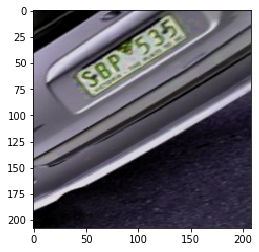

In [18]:
plt.imshow(XX)

Ground truth ที่ใช้ในการ train model

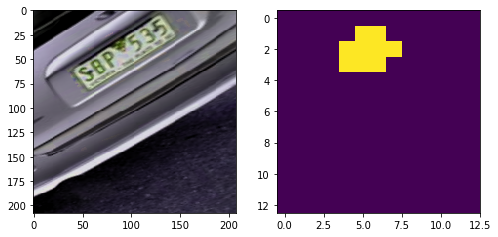

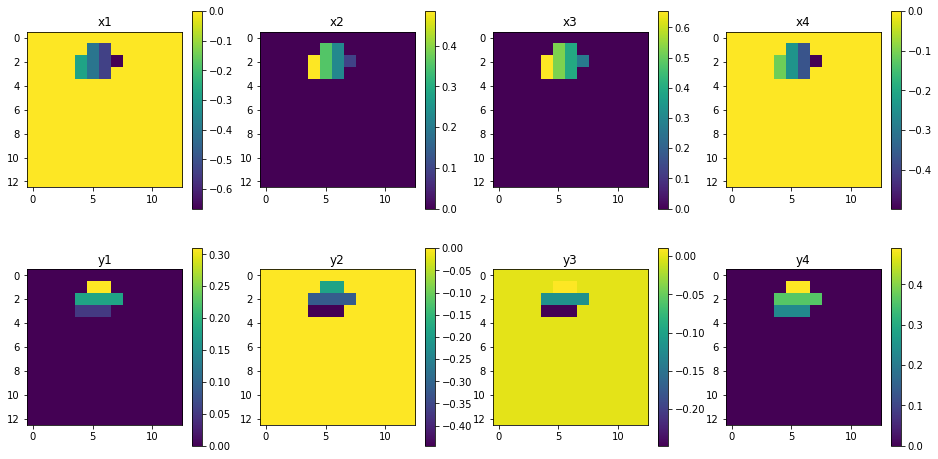

In [19]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(XX)
axs[1].imshow(YY[:,:,0])

fig, axs = plt.subplots(2,4, figsize=(16,8))
for i, ax in enumerate(axs[0]):
    pim = ax.imshow(YY[:,:,i*2+1])
    fig.colorbar(pim, ax=ax)
    ax.set_title('x%d'%(i+1))
for i, ax in enumerate(axs[1]):
    pim = ax.imshow(YY[:,:,i*2+2])
    fig.colorbar(pim, ax=ax)
    ax.set_title('y%d'%(i+1))

ตัวอย่างภาพทะเบียนหลัง data augmentation

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


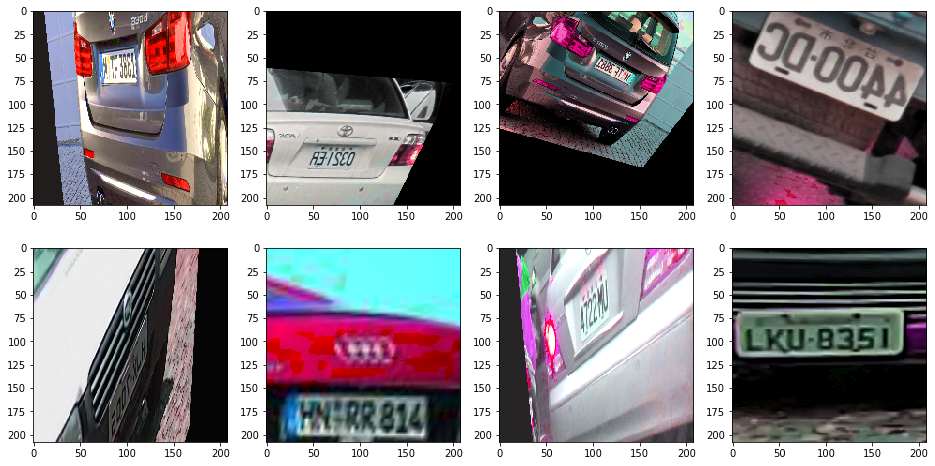

In [20]:
fig, axs = plt.subplots(2,4, figsize=(16,8))
for rows in axs:
    for ax in rows:
        data_item = random.choice(Data)
        XX,YY = td.process_data_item(data_item, dim, model_stride)
        ax.imshow(cv2.cvtColor(XX, cv2.COLOR_BGR2RGB))
fig.show()

เวลา train model ให้รันคำสั่งนี้ (อย่าลืมรัน `create-model.py` เพื่อกำหนด network ก่อน train ด้วย)

In [21]:
#!python train-detector.py --model models/eccv-model-scracth --name my-trained-model --train-dir samples/train-detector